# Анализ поведения пользователей в мобильном приложении "Ненужные вещи"

Пользователи сервиса "Ненужные вещи" совершают много действий в мобильном приложении. В нем они продают свои ненужные вещи, размещая их на доске объявлений. В имеющихся данных есть инсайты, которые позволят приложению стать лучшим в категориии продажи ненужных вещей. В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года. Необходимо провести анализ поведения пользователей в мобильном приложении.

Для этого нам необходимо выполнить следующие задачи:

1. Проанализировать связь целевого события - просмотра контактов - и других действий пользователей.
2. Оценить какие действия чаще совершают те пользователи, которые просматривают контакты.
3. Провести исследовательский анализ данных.
4. Проанализировать влияние событий на совершение целевого события
5. Проверить статистические гипотезы

**Описание данных**

В нашем распоряжении два датасета:

[mobile_dataset.csv](https://disk.yandex.ru/d/KaN8Wffo4Q510Q)
 
[mobile_sources.csv](https://disk.yandex.ru/d/RkfgQSEt-zD6Uw)

Файл mobile_dataset.csv ханит информацию о пользователях и совершенными ими действиях. Файл mobile_sources.csv хранит инфомацию об источниках привлечения пользователей.

Структура mobile_sources.csv:
- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Структура mobile_dataset.csv: 
- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:
- advert_open — открыл карточки объявления,
- photos_show — просмотрел фотографий в объявлении,
- tips_show — увидел рекомендованные объявления,
- tips_click — кликнул по рекомендованному объявлению,
- contacts_show и show_contacts — посмотрел номер телефона,
- contacts_call — позвонил по номеру из объявления,
- map — открыл карту объявлений,
- search_1—search_7 — разные действия, связанные с поиском по сайту,
- favorites_add — добавил объявление в избранное.

**Цель исследования**

Анализ поведения пользователей и разбор сценариев использования приложения "Ненужные вещи" для дальнейшей сегментации аудитории.

**Материалы:**
Презентация [https://disk.yandex.ru/i/02-lh48EyjDekA]

## Загрузка данных и подготовка их к анализу

Для начала импортируем все необходимые библиотеки и выполним предобработку данных

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

import seaborn as sns

from scipy import stats as st

import datetime as dt

import requests

import os

import re

from tqdm.auto import tqdm

from datetime import datetime, timedelta

import math as mth

import plotly.express as px
from plotly import graph_objects as go

В нашем распоряжении два датасета: mobile_dataset.csv и mobile_sources.csv. Откроем их и изучим общую информацию

In [2]:
# загружаем данные датасета mobile_dataset.csv и выводим общую информацию
data = pd.read_csv('/datasets/mobile_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [3]:
# выводим первые 5 строк на экран
display(data.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
# загружаем данные датасета mobile_sources.csv и выводим общую информацию
sources = pd.read_csv('/datasets/mobile_soures.csv')
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [5]:
# выводим первые 5 строк на экран
display(sources.head())

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Приведем названия колонок к единому формату. Для этого в названиях колонок первого датасета заменим "." вместо пропусков на "_", а во втором-  изменим название колонки "userId" на "user_id".

In [6]:
data.columns = data.columns.str.replace(".", "_", regex=True)
print(data.columns)
print()

sources.columns = sources.columns.str.replace("userId", "user_id")
print(sources.columns)

Index(['event_time', 'event_name', 'user_id'], dtype='object')

Index(['user_id', 'source'], dtype='object')


Выделим дату совершения события в отдельную колонку и отобразим получившися датафрейм.

In [7]:
# добавляем колонку event_date

data['event_date'] = pd.DatetimeIndex(data['event_time']).date.astype('datetime64[ns]')
# выводим первые строки датафрейма на экран
display(data.head())

,event_time,event_name,user_id,event_date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07


Для удобства работы объединим оба датасета в один по user_id и выведем получившийся результат на экран.

In [8]:
data_all = data.merge(sources, on=['user_id'], how='left')
display(data_all.head())

,event_time,event_name,user_id,event_date,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex


Данные в event_time приведем к типу date_time, округлив значения до секунд.

In [9]:
data_all['event_time'] = pd.to_datetime(data['event_time'], format ='%Y-%m-%d %H:%M:%S')
data_all['event_time'] = data_all['event_time'].dt.round('S')
display(data_all.dtypes)

event_time    datetime64[ns]
event_name            object
user_id               object
event_date    datetime64[ns]
source                object
dtype: object

Посмотрим, есть ли в таблице пропуски.

In [10]:
data_all.isnull().sum()

event_time    0
event_name    0
user_id       0
event_date    0
source        0
dtype: int64

Пропусков в данных нет. Проверим наличие дубликатов.

In [11]:
data_all.duplicated().sum()

1118

В таблице нашлось 1118 дубликатов. Удалим их.

In [12]:
data_all = data_all.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов в таблице после удаления:',data.duplicated().sum())

Количество дубликатов в таблице после удаления: 0


Посмотрим сколько осталось строк в таблице после удаления дубликатов.

In [13]:
data_all.shape

(73079, 5)

Проверим минимальные и максимальные значения колонки event_time

In [14]:
print('Минимальная дата события:', data_all['event_time'].min())

Минимальная дата события: 2019-10-07 00:00:00


In [15]:
print('Максимальная дата события:', data_all['event_time'].max())

Максимальная дата события: 2019-11-03 23:58:13


Проверяем количество уникальных значений в колонке event_name

In [16]:
print(data_all.groupby('event_name')['user_id'].count().sort_values(ascending=False))

event_name
tips_show        39892
photos_show       9372
advert_open       6145
contacts_show     4302
map               3760
search_1          3489
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      538
search_3           521
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: user_id, dtype: int64


Видим, что присутствуют похожие события contacts_show и show_contacts, вероятнее всего это одно и то же действие, поэтому объединим их.

In [17]:
# объединяем данные по действиям contacts_show и show_contacts
data_all['event_name'] = data_all['event_name'].replace('show_contacts', 'contacts_show')
print(data_all.groupby('event_name')['user_id'].count().sort_values(ascending=False))

event_name
tips_show        39892
photos_show       9372
advert_open       6145
contacts_show     4381
map               3760
search_1          3489
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      538
search_3           521
search_6           460
search_2           324
search_7           222
Name: user_id, dtype: int64


Посмотрим сколько у нас имеется уникальных user_id

In [18]:
print('Количество уникальных пользователей:', data_all['user_id'].nunique())

Количество уникальных пользователей: 4293


**Вывод**

На данном этапе мы привели названия колонок датафреймов mobile_dataset.csv и mobile_soures.csv к единому стандарту написания. Датафреймы были объединены в один по ключу уникального номера пользователя. В колонке event_time данные были приведены к типу datetime и округлены до секунд. Пропуски в таблице выявлены не были. Проверка на дубликаты выявила 1 118 задублированных записей, которые потом были удалены. Проверка минимальной и максимальной даты событий показала, что данные предоставлены за период с 7 октября 2019 г (00:00:00) по 3 ноября 2019 г (23:58:13).
Анализ данных по целевому действию просмотр контактов, записанных двумя разными способами, показал, что действия ничем не отличаются по содержанию, а появление небольшого числа записей (79 show_contacts) с зеркальным написанием скорее всего связано с выгрузкой данных из разных БД. Данные были объединены под записью contacts_show. Итоговый датасет содержит информацию о 4 293 уникальных пользователях.

## Исследовательский анализ данных

### Общий анализ данных о действиях пользователей

Ознакомимся со статистической информацией по количеству действий пользователей приложения.

In [19]:
print("Количество пользователей =", data_all['user_id'].nunique())
print("Количество событий =", data_all['event_name'].count())

Количество пользователей = 4293
Количество событий = 73079


Посмотрим как распределяются действия, совершенные пользователями

In [20]:
# создаем переменную, отражающую количество действий на уникального пользователя 
data_all_users = data_all.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_time', aggfunc = ('count'))
display(data_all_users.count())

event_name
advert_open       751
contacts_call     213
contacts_show     981
favorites_add     351
map              1456
photos_show      1095
search_1          787
search_2          242
search_3          208
search_4          474
search_5          663
search_6          330
search_7          157
tips_click        322
tips_show        2801
dtype: int64

Вычислим среднее количество событий, которые совершает один пользователь за день

In [21]:
print('Количество событий, совершаемых одним пользователем за день -', round(data_all.groupby('user_id')['event_name'].count().mean(), 1))

Количество событий, совершаемых одним пользователем за день - 17.0


In [22]:
# выводим статистическую информацию по количеству действий всех пользователей

display(data_all_users.describe().T.sort_values(by='count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
tips_show,2801.0,14.242056,23.026878,1.0,4.0,8.0,15.0,346.0
map,1456.0,2.582418,4.613599,1.0,1.0,1.0,3.0,71.0
photos_show,1095.0,8.558904,13.002459,1.0,3.0,5.0,9.0,175.0
contacts_show,981.0,4.465851,8.982642,1.0,1.0,2.0,4.0,137.0
search_1,787.0,4.433291,6.003312,1.0,2.0,3.0,5.0,68.0
advert_open,751.0,8.182423,12.608780,1.0,2.0,4.0,8.5,131.0
search_5,663.0,1.582202,1.806864,1.0,1.0,1.0,2.0,25.0
search_4,474.0,1.478903,1.986364,1.0,1.0,1.0,1.0,35.0
favorites_add,351.0,4.028490,6.284610,1.0,1.0,2.0,5.0,63.0


Параметр tips_show показывается всем пользователям автоматически, т.е. осуществление этого действия не зависит от воли пользователя, поэтому параметр не будет учитываться в анализе. Исключим его.

In [23]:
# создаем переменную, отражающую количество действий на уникального пользователя за период
# на всем датасете, исключаем параметр tips_show

data_all_users = data_all.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_time', aggfunc = ('count'))\
.drop('tips_show', axis=1)
# выводим статистическую информацию по кол-ву действий всех пользователей

display(data_all_users.describe().T.sort_values(by='count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
map,1456.0,2.582418,4.613599,1.0,1.0,1.0,3.0,71.0
photos_show,1095.0,8.558904,13.002459,1.0,3.0,5.0,9.0,175.0
contacts_show,981.0,4.465851,8.982642,1.0,1.0,2.0,4.0,137.0
search_1,787.0,4.433291,6.003312,1.0,2.0,3.0,5.0,68.0
advert_open,751.0,8.182423,12.608780,1.0,2.0,4.0,8.5,131.0
search_5,663.0,1.582202,1.806864,1.0,1.0,1.0,2.0,25.0
search_4,474.0,1.478903,1.986364,1.0,1.0,1.0,1.0,35.0
favorites_add,351.0,4.028490,6.284610,1.0,1.0,2.0,5.0,63.0
search_6,330.0,1.393939,1.206351,1.0,1.0,1.0,1.0,17.0


**Вывод**

Самым популярным действием среди аудитории приложения Ненужные вещи является tips_show (увидел рекомендованные объявления). Так как данный параметр показывается автоматически и не зависит от воли пользователя, не будем учитывать его в дальнейшем анализе.
Следовательно, самым популярным действием (совершенным по воле пользователя) является *открытие карты объявления* - 1456 клиентов открыли карту объявлений.
Следом идет *просмотр фотографий объявления*, это действие совершили 1095 клиентов.
Замыкает ТОП-3 действий в приложении - *просмотр номера телефона*, далее в исследовнии именно это действие будем рассматривать как целевое, ведь именно оно приводит к покупке, пользователь может сохранить просмотренный контакт и позвонить ему в удобное для себя время, чтобы договориться о сделке. В нашей выборке контакты посмоторел 981 пользователь.
    Самыми непопулярными действиями пользователей являются: звонок по объявлению (из приложения), скорее всего большинство пользователей, как мы уже сказали ранее, сохраняют просмотренный контакт себе на телефон и звонят позже, в удобное время, а также действия, связанные с поиском по сайту search_3 и search_7.

### Анализ информации о количестве действий пользователей, осуществивших целевое действие

Целевым действием у нас является contacts_show (просмотр контакта), так как пользователь может совершить звонок по объявлению, не используя для этого приложение, поэтому contacts_call не подходит. Создадим выборку данных по пользователям, осуществившим целевое действие. И ознакомимся со статистической информацией по количеству действий пользователей, осуществивших целевое действие.

In [24]:
display(data_all_users.shape[0]) # общее количество пользователей

4293

In [25]:
# выборка данных по пользователям, осуществивших целевое действие 
data_target = data_all_users[data_all_users['contacts_show'] >0]
display(data_target.shape[0])

981

In [26]:
# процент пользователей, совершивших целевое действие от общего количества пользователей
target_share = (data_target.shape[0]/data_all_users.shape[0])*100
display(target_share)

22.851153039832283

Целевое действие (просмотр контакта) осуществили 981 пользователей из 4293, что составляет около 22.85% от общего количества пользователей.

In [27]:
# статистическая информация по количеству действий пользователей, осуществивших целевое действие

display(data_target.describe().T.sort_values(by='count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
contacts_show,981.0,4.465851,8.982642,1.0,1.0,2.0,4.00,137.0
photos_show,339.0,10.315634,18.060813,1.0,2.0,4.0,10.00,175.0
map,289.0,3.688581,6.919169,1.0,1.0,2.0,4.00,66.0
search_1,237.0,5.654008,9.072128,1.0,1.0,3.0,5.00,68.0
contacts_call,213.0,2.525822,2.370324,1.0,1.0,2.0,3.00,17.0
advert_open,138.0,11.485507,15.951677,1.0,2.0,6.0,13.00,99.0
favorites_add,136.0,3.095588,3.812025,1.0,1.0,1.0,4.00,23.0
search_5,114.0,2.184211,3.144220,1.0,1.0,1.0,2.00,25.0
tips_click,100.0,3.320000,4.004745,1.0,1.0,2.0,4.00,30.0


**Вывод**

Пользователи, совершившие целевое действие(просмотр контракта), чаще всего смотрели фото в объявлении (339 клиентов), открывали карту (289 клиентов) и совершали действие search_1 по поиску на сайте. Меньше всего эти пользователи совершали действия по поиску search_6, search_3, search_7.

### Длительность сессий

За *длительность сессии* примем разницу между временем осуществления первого действия и последнего действия в рамках одного календарного дня для каждого уникального пользователя.

Создадим таблицу длительности сессий:

In [28]:
# отсортируем  датасет по user_id и event_time
data_all.sort_values(['user_id', 'event_time'])

# создаем таблицу максимальных значений времени осуществления действия униканым пользователем в рамках одного дня
data_session_dur_max = data_all.groupby(['user_id', 'event_date'])['event_time'].agg('max').reset_index()

# создаем таблицу минимальных значений времени осуществления действия униканым пользователем в рамках одного дня
data_session_dur_min = data_all.groupby(['user_id', 'event_date'])['event_time'].agg('min').reset_index()

# объединяем таблицы на уровне уникального пользователя и дня осуществления действий
data_session_dur = data_session_dur_max.merge(data_session_dur_min, on = ['user_id', 'event_date'], how = 'left')\
.rename(columns = {'event_time_x':'event_time_max', 'event_time_y':'event_time_min'})

# создаем колонку с расчетом разницы между максимальными и минимальными значениями осуществления действий
# одним уникальным пользователейм в один день
data_session_dur['session_duration'] = (data_session_dur['event_time_max'] - data_session_dur['event_time_min']).dt.seconds

# проверяем типы данных созданной таблицы и выводим первые строки на экран
print(data_session_dur.dtypes)
display(data_session_dur.head())

user_id                     object
event_date          datetime64[ns]
event_time_max      datetime64[ns]
event_time_min      datetime64[ns]
session_duration             int64
dtype: object


,user_id,event_date,event_time_max,event_time_min,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:49:42,2019-10-07 13:39:46,596
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:42:23,2019-10-09 18:33:56,507
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 20:07:30,2019-10-21 19:52:31,899
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:30:53,2019-10-22 11:18:15,758
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:59:55,2019-10-19 21:34:34,1521


Посмотрим на статистические данные о длительности сессий.

In [29]:
data_session_dur['session_duration'].describe()

count     7817.000000
mean      4981.994371
std      11410.078733
min          0.000000
25%        147.000000
50%        708.000000
75%       2925.000000
max      85049.000000
Name: session_duration, dtype: float64

В течении изучаемого периода времени пользователи осуществили **7 817 сессий**.
Минимальная длительность сессии зафиксирована равной 0. Максимальная сессия равна 85049 секунды или практически равна суткам. Из-за большого разброса данных, среднюю продолжительность сессии рассчитаем по медиане, которая равна 708 секунд, что равняется практически 12 минутам.

In [30]:
# выводим информацию о количестве сессий по длительности

display(data_session_dur['session_duration']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'Длительность сессии', 'session_duration':'Количество сессий'})
        .sort_values(by='Длительность сессии', ascending=False).T)

,2933,1368,2228,3608,2910,1526,2563,2024,1212,2075,...,8,58,16,178,36,1,2,5,7,0
Длительность сессии,85049,84643,84426,83173,82802,82528,81711,81697,81445,81125,...,9,8,7,6,5,4,3,2,1,0
Количество сессий,1,1,1,1,1,1,1,1,1,1,...,12,8,10,5,9,22,17,13,12,1012


 Посмотрим на распределение данных о длительности сессий на гистограмме

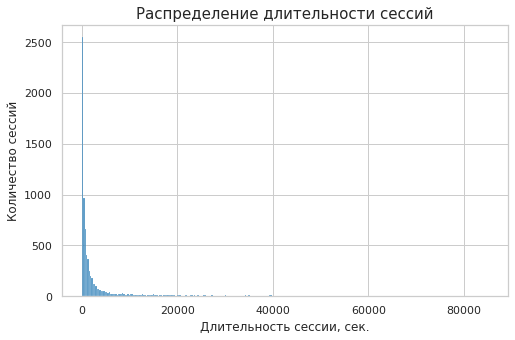

In [31]:
plt.figure(figsize=(8, 5))
sns.set(style='whitegrid', palette='tab10')
sns.histplot(data_session_dur['session_duration'], kde=False)
plt.title('Распределение длительности сессий', fontsize=15)
plt.ylabel('Количество сессий', fontsize=12)
plt.xlabel('Длительность сессии, сек.', fontsize=12)
plt.show()


Ознакомимся с информацией о минимальных значениях длительности сессий.

In [32]:
display(data_session_dur[data_session_dur['session_duration'] == 0]\
        .groupby('event_date')['session_duration']\
        .count()\
        .describe())

count    28.000000
mean     36.142857
std      10.748693
min      13.000000
25%      27.750000
50%      38.500000
75%      44.250000
max      54.000000
Name: session_duration, dtype: float64

Минимальных сессий, равных нулю в данных насчитывается 28 штук. Распределение нулевых сессий по дням достаточно равномерно, аномалии отсутсвуют. Вероятнее всего нулевые сессий возникли после округления данных до секунд. 

Посмотрим на информацию о максимальных значениях длительности сессий. Как мы уже выяснили, максимальная сессия равна 85049 секунд. Выведем информацию о данной сессии.

In [33]:
display(data_session_dur[data_session_dur['session_duration'] == 85049])

,user_id,event_date,event_time_max,event_time_min,session_duration
660,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-03,2019-11-03 23:47:36,2019-11-03 00:10:07,85049


Пользователь 12681fdf-d1d1-454b-9b92-e8a3ccfaf07b совершил максимально длительную сессию. Проверим остальные сессии данного пользователя:

In [34]:
display(data[data['user_id'] == '12681fdf-d1d1-454b-9b92-e8a3ccfaf07b'])

,event_time,event_name,user_id,event_date
70705,2019-11-02 18:54:27.098754,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-02
70734,2019-11-02 19:13:42.008670,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-02
71342,2019-11-03 00:10:07.175263,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-03
72779,2019-11-03 16:54:45.124660,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-03
74181,2019-11-03 23:47:35.841615,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-03


Максимальная длительность сессии составила 85 049 секунд, или сутки. Клиент начал сессию поздно ночью 3 ноября 2011 года и, вероятнее всего, забыл выйти из приложения. За сутки было осуществлено 3 действия по просмотру фотографий.

**Вывод**

В течении изучаемого периода времени пользователи осуществили 7 817 сессий. Средняя длительность сессии составила 4 982 секунды, или 83 минуты. Минимальная длительность сессии зафиксирована равной 0. 
Минимальных сессий, равных нулю в данных насчитывается 28 штук. Распределение нулевых сессий по дням достаточно равномерно, аномалии отсутсвуют. Вероятнее всего нулевые сессий возникли после округления данных до секунд.
Максимальная сессия равна 85049 секунд, или сутки. Её осуществил пользователь 12681fdf-d1d1-454b-9b92-e8a3ccfaf07b. Клиент начал сессию поздно ночью 3 ноября 2011 года и, вероятнее всего, забыл выйти из приложения. За это время он осуществил 3 действия по просмотру фотографий.

### Сценарии поведения пользователей

Для выделения сессии пользователей будем придерживаться подхода, что сессия = календарному дню, чтобы не учитывать ситуации, когда действие было совершено в один день, а потом другое действие через несколько дней. 

In [121]:
data_scenario = data_all.sort_values(['user_id', 'event_time'])
# добавляем столбец session_id

data_scenario['session_id'] = data_all.groupby(['user_id','event_date']).ngroup()

display(data_scenario)

,event_time,event_name,user_id,event_date,source,session_id
795,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0
796,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0
799,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0
810,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0
818,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0
...,...,...,...,...,...,...
71487,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google,7816
71492,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google,7816
71578,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google,7816
71582,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google,7816


Для наглядного отображения построим **диаграмму Сэнкей**

Для построения диаграммы определим пары source-target, а также пронумеруем эти пары в соответствии с временем наступления события - это будет шаг между событиями.

Но перед этим удалим дубликаты

In [122]:
data_scenario.drop_duplicates(subset=['event_name', 'session_id'], inplace=True)
data_scenario

,event_time,event_name,user_id,event_date,source,session_id
795,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other,0
6471,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,other,1
6495,2019-10-09 18:40:29,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,other,1
35878,2019-10-21 19:52:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,other,2
35885,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,other,2
...,...,...,...,...,...,...
65880,2019-11-01 00:24:31,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,google,7814
68457,2019-11-02 01:16:49,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,google,7815
69586,2019-11-02 18:17:41,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,google,7815
71226,2019-11-03 14:32:56,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google,7816


In [123]:
def add_features(df):
    
    """Функция генерации новых столбцов для исходной таблицы"""
    
    # сортируем по id и времени
    sorted_data = data_scenario.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_data['step'] = sorted_data.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_data['source'] = sorted_data['event_name']
    # добавляем целевые узлы
    sorted_data['target'] = sorted_data.groupby('session_id')['source'].shift(-1)
    
    # возврат таблицы без имени событий
    return sorted_data.drop(['event_name'], axis=1)
  
# преобразуем таблицу
data_scenario = add_features(data)
data_scenario

,event_time,user_id,event_date,source,session_id,step,target
795,2019-10-07 13:39:46,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,tips_show,0,1,NaN
6471,2019-10-09 18:33:56,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,map,1,1,tips_show
6495,2019-10-09 18:40:29,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,tips_show,1,2,NaN
35878,2019-10-21 19:52:31,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,tips_show,2,1,map
35885,2019-10-21 19:53:39,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,map,2,2,NaN
...,...,...,...,...,...,...,...
65880,2019-11-01 00:24:31,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,tips_show,7814,1,NaN
68457,2019-11-02 01:16:49,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,tips_show,7815,1,contacts_show
69586,2019-11-02 18:17:41,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,contacts_show,7815,2,NaN
71226,2019-11-03 14:32:56,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,tips_show,7816,1,contacts_show


Удалим пропущенные значения

In [134]:
data_scenario = data_scenario.dropna()

Посмотрим сколько событий совершается в одну сессию:

In [135]:
print('Среднее количество событий в сессии: ' + str(data_scenario.groupby('session_id')['event_time'].count().mean()))
print('Медианное количество событий в сессии: ' + str(data_scenario.groupby('session_id')['event_time'].count().median()))
print('Минимальное количество событий в сессии: ' + str(data_scenario.groupby('session_id')['event_time'].count().min()))
print('Максимальное количество событий в сессии: ' + str(data_scenario.groupby('session_id')['event_time'].count().max()))

Среднее количество событий в сессии: 1.8499889697771894
Медианное количество событий в сессии: 1.0
Минимальное количество событий в сессии: 1
Максимальное количество событий в сессии: 8


Так как среднее и медианное слишком малы, для большей репрезентативности выберем среднее между максимальным и минимальным количеством событий и отобразим на диаграмме 4 шага.

In [126]:
# удалим все пары source-target, шаг которых превышает 4
# и сохраним полученную таблицу в отдельную переменную
df_comp = data_scenario[data_scenario['step'] <= 4].copy().reset_index(drop=True)

In [127]:
def get_source_index(df):
    
    """Функция генерации индексов source"""
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = data_scenario[data_scenario['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

In [137]:
# КОД РЕВЬЮЕРА

source_indexes

{1: {'sources': ['tips_show',
   'map',
   'search_1',
   'photos_show',
   'contacts_show',
   'search_7',
   'search_4',
   'advert_open',
   'search_6',
   'search_5',
   'favorites_add',
   'search_2',
   'search_3',
   'tips_click'],
  'sources_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  'sources_dict': {'tips_show': 0,
   'map': 1,
   'search_1': 2,
   'photos_show': 3,
   'contacts_show': 4,
   'search_7': 5,
   'search_4': 6,
   'advert_open': 7,
   'search_6': 8,
   'search_5': 9,
   'favorites_add': 10,
   'search_2': 11,
   'search_3': 12,
   'tips_click': 13}},
 2: {'sources': ['tips_show',
   'map',
   'photos_show',
   'advert_open',
   'search_5',
   'search_4',
   'contacts_call',
   'contacts_show',
   'search_1',
   'tips_click',
   'search_3',
   'favorites_add',
   'search_2',
   'search_6',
   'search_7'],
  'sources_index': [14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28],
  'sources_dict': {'tips

In [138]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [139]:
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

In [140]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [159]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        
        print(source_indexes[step]['sources_dict']) # КОД РЕВЬЮЕРА
        
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']
        

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг:   0%|          | 0/4 [00:00<?, ?it/s]

{'tips_show': 0, 'map': 1, 'search_1': 2, 'photos_show': 3, 'contacts_show': 4, 'search_7': 5, 'search_4': 6, 'advert_open': 7, 'search_6': 8, 'search_5': 9, 'favorites_add': 10, 'search_2': 11, 'search_3': 12, 'tips_click': 13}


  0%|          | 0/14 [00:00<?, ?it/s]

{'tips_show': 14, 'map': 15, 'photos_show': 16, 'advert_open': 17, 'search_5': 18, 'search_4': 19, 'contacts_call': 20, 'contacts_show': 21, 'search_1': 22, 'tips_click': 23, 'search_3': 24, 'favorites_add': 25, 'search_2': 26, 'search_6': 27, 'search_7': 28}


  0%|          | 0/15 [00:00<?, ?it/s]

{'favorites_add': 29, 'contacts_show': 30, 'map': 31, 'search_6': 32, 'tips_show': 33, 'search_7': 34, 'contacts_call': 35, 'advert_open': 36, 'tips_click': 37, 'search_5': 38, 'search_1': 39, 'photos_show': 40, 'search_4': 41, 'search_2': 42, 'search_3': 43}


  0%|          | 0/15 [00:00<?, ?it/s]

{'contacts_show': 44, 'contacts_call': 45, 'search_5': 46, 'search_4': 47, 'search_3': 48, 'tips_show': 49, 'tips_click': 50, 'map': 51, 'advert_open': 52, 'search_2': 53, 'favorites_add': 54, 'search_1': 55, 'search_6': 56, 'photos_show': 57, 'search_7': 58}


In [162]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, width=800, height=500)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

In [163]:
senkey_diagram.show()

На основании диаграммы Сэнкей можно выделить следующие распространенные сценарии поведения пользователей:

 1) Пользователь совершил действие по поиску на сайте (search_1), возможно, искал интересующий его товар. Далее: 
   - пользователь стал просматривать фотографии в объявлении
   - посмотрел контакт (совершил целевое действие)
   
    
2) Еще один популярный сценарий начинается с просмотра карты размещенных объявлений, вероятнее всего, пользователи ищут товары недалеко от собственного дома или места, из которого им будет удобно забрать товар. После просмотра карты можно выделить следующие сценарии действий пользователей:
  - просмотр рекомендованных объявлений
  - просмотр контакта (совершил целевое действие)

3) Пользователь начал сеанс с просмотра рекомендованного объявления. Далее он совершает следующие действия:
   - открытие карты объявлений
   - открытие карточки объявления
   - просмотр контакта (совершил целевое действие)

In [48]:
target_users = data_all.query('event_name == "search_1"')['user_id']
target_users_unique = target_users.nunique()

# Формируем датасет с учетом выявленного сценария

target_events = data_all.query('user_id in @target_users')
target_events  = target_events.query('event_name == ["photos_show", "search_1", "contacts_show"]')

# Находим количество пользователей и их долю

users_share = (
    target_events
    .groupby('event_name')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'user_id': 'total_users'})
)
users_share['share'] = round(users_share['total_users'] / target_users_unique * 100, 2)
users_share

,event_name,total_users,share
0,search_1,787,100.00
1,photos_show,643,81.70
2,contacts_show,237,30.11


In [49]:
# Строим воронку

fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = users_share['event_name'],
    x = users_share['total_users'],
textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка конверсии пользователей, начавших сессию с search_1')
fig.show()

In [50]:
target_users_2 = data_all.query('event_name == "map"')['user_id']
target_users_unique_2 = target_users_2.nunique()

# Формируем датасет с учетом выявленного сценария

target_events_2 = data_all.query('user_id in @target_users_2')
target_events_2  = target_events_2.query('event_name == ["map", "tips_show", "contacts_show"]')

# Находим количество пользователей и их долю

users_share_2 = (
    target_events_2
    .groupby('event_name')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'user_id': 'total_users'})
)
users_share_2['share'] = round(users_share_2['total_users'] / target_users_unique_2 * 100, 2)

# Строим воронку

fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = users_share_2['event_name'],
    x = users_share_2['total_users'],
textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка конверсии пользователей, начавших сессию с map')
fig.show()

In [51]:
target_users_3 = data_all.query('event_name == "tips_show"')['user_id']
target_users_unique_3 = target_users_3.nunique()

# Формируем датасет с учетом выявленного сценария

target_events_3 = data_all.query('user_id in @target_users_3')
target_events_3 = target_events_3.query('event_name == ["map", "advert_open", "tips_show", "contacts_show"]')

# Находим количество пользователей и их долю

users_share_3 = (
    target_events_3
    .groupby('event_name')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'user_id': 'total_users'})
)
users_share_3['share'] = round(users_share_3['total_users'] / target_users_unique_3 * 100, 2)

# Строим воронку

fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = users_share_3['event_name'],
    x = users_share_3['total_users'],
textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка конверсии пользователей, начавших сессию с tips_show')
fig.show()

**Вывод**

Как было принято, в среднем, пользователь во время сессии совершает 1-4 действий по сайту. К целевому действию (просмотр контакта) он может прийти уже после первого шага, а может и совершив несколько действий в приложении. Среди рассмотренных нами сценариев поведения пользователей, можем сделать вывод, что пользователи, которые начали свои сессии с совершения действий по поиску на сайте и открытия карты объявлений быстрее совершают целевое действие (просмотр контакта), чем те, кто начал сеанс с просмотра рекомендованного объявления. Последние совершают на одно действие больше. Лучшую конверсию из трех расммотренных сценариев действий показывают пользователи, начавшие сессию с поиска по сайту, 30% от начавших поиск по итогу сессии смотрят контакт, что гораздо выше, чем у пользователей, начавших сессию с просмотра рекомендованного объявления или просмотра карты. 

### Различие времени между распространенными событиями пользователей

Рассмотрим как различается время между первым действием пользователя в приложении и целевым действием- просмотром контакта. 
Посчитаем сколько пользователей совершали "contacts_show" и сколько раз.

In [52]:
contact_show_users = data_all.query('event_name == "contacts_show"').groupby('user_id')['event_name'].count().sort_values(ascending=False)
print('Количество пользователей, совершивших целевое действие =', len(contact_show_users))

Количество пользователей, совершивших целевое действие = 981


Теперь посмотрим сколько раз было совершено целевое действие (просмотр контакта)

In [53]:
data_all.query('event_name == "contacts_show"').groupby('event_name')['event_name'].count()

event_name
contacts_show    4381
Name: event_name, dtype: int64

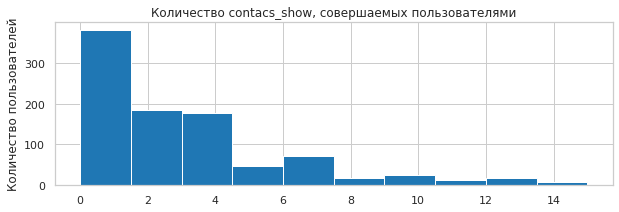

In [54]:
contact_show_users.hist(figsize=(10,3), bins=10, range=(0,15))
plt.title('Количество contacs_show, совершаемых пользователями')
plt.ylabel('Количество пользователей');
plt.show()

За период в 28 дней из 981 пользователей, совершивших целевое действие (просмотр контакта), в среднем каждый пользователей совершил целевое действие от 1 до 4 раз.

Далее посмотрим как различается **время от первого действия пользователя в приложении до целевого.**

Создадим таблицу пользователей, где присутствуют дата и время первого события и дата и время первого целевого (первого, так как возможно каждый пользователь мог совершать несколько целевых событий). За основу возьмем таблицу с выделенными сессиями, где сессия будет считаться в рамках одного дня.

In [55]:
data_sessions = data_all.sort_values(['user_id', 'event_time'])
# добавляем столбец session_id
data_sessions['session_id'] = data_all.groupby(['user_id','event_date']).ngroup()
data_sessions.drop_duplicates(subset=['event_name', 'session_id'], inplace=True)
data_sessions = data_sessions.dropna() 

Для начала сгруппируем таблицу по первому времени взаимодействия с приложением в рамках одной сессии.

In [56]:
user_first_event = data_sessions.groupby('session_id')['event_time'].min().reset_index()
user_first_event.head()

,session_id,event_time
0,0,2019-10-07 13:39:46
1,1,2019-10-09 18:33:56
2,2,2019-10-21 19:52:31
3,3,2019-10-22 11:18:15
4,4,2019-10-19 21:34:34


Добавим название первого совершенного действия

In [57]:
def event_min(row):
    l = (data_sessions.loc[(data_sessions['session_id']==row['session_id']) & (data_sessions['event_time']==row['event_time']),'event_name']).values #.astype(str)
    return l[0]
    
user_first_event['first_event'] = user_first_event.apply(event_min, axis=1)
user_first_event

,session_id,event_time,first_event
0,0,2019-10-07 13:39:46,tips_show
1,1,2019-10-09 18:33:56,map
2,2,2019-10-21 19:52:31,tips_show
3,3,2019-10-22 11:18:15,map
4,4,2019-10-19 21:34:34,search_1
...,...,...,...
7812,7812,2019-10-29 13:58:48,tips_show
7813,7813,2019-10-30 00:15:43,contacts_show
7814,7814,2019-11-01 00:24:31,tips_show
7815,7815,2019-11-02 01:16:49,tips_show


Далее вычислим время, когда пользователь совершил целевое действие (просмотр контактов)

In [58]:
user_first_contacts_show = data_sessions.query('event_name == "contacts_show"').groupby('session_id')['event_time'].min().reset_index()
user_first_contacts_show.columns = ['session_id', 'time_first_contacts_show']
user_first_contacts_show

,session_id,time_first_contacts_show
0,5,2019-10-20 19:17:19
1,7,2019-10-29 21:26:40
2,8,2019-10-30 08:01:05
3,9,2019-11-03 17:12:10
4,17,2019-10-25 16:44:41
...,...,...
1439,7811,2019-10-28 15:00:43
1440,7812,2019-10-29 14:00:14
1441,7813,2019-10-30 00:15:43
1442,7815,2019-11-02 18:17:41


Объединим две таблицы и найдём разницу во времени

In [59]:
target = user_first_contacts_show.merge(user_first_event, on='session_id', how='left')
target.columns = ['session_id', 'time_first_contacts_show', 'time_first_event', 'first_event']
target['delta_time'] = target['time_first_contacts_show'] - target['time_first_event']
target

,session_id,time_first_contacts_show,time_first_event,first_event,delta_time
0,5,2019-10-20 19:17:19,2019-10-20 18:49:24,search_1,0 days 00:27:55
1,7,2019-10-29 21:26:40,2019-10-29 21:18:25,search_1,0 days 00:08:15
2,8,2019-10-30 08:01:05,2019-10-30 07:50:46,search_1,0 days 00:10:19
3,9,2019-11-03 17:12:10,2019-11-03 17:12:10,contacts_show,0 days 00:00:00
4,17,2019-10-25 16:44:41,2019-10-25 16:44:41,contacts_show,0 days 00:00:00
...,...,...,...,...,...
1439,7811,2019-10-28 15:00:43,2019-10-28 11:49:39,tips_show,0 days 03:11:04
1440,7812,2019-10-29 14:00:14,2019-10-29 13:58:48,tips_show,0 days 00:01:26
1441,7813,2019-10-30 00:15:43,2019-10-30 00:15:43,contacts_show,0 days 00:00:00
1442,7815,2019-11-02 18:17:41,2019-11-02 01:16:49,tips_show,0 days 17:00:52


Отсортируем полученную таблицу

In [60]:
target.sort_values(by='delta_time')

,session_id,time_first_contacts_show,time_first_event,first_event,delta_time
1036,5713,2019-10-22 19:19:08,2019-10-22 19:19:08,contacts_show,0 days 00:00:00
469,2612,2019-10-20 15:59:08,2019-10-20 15:59:08,contacts_show,0 days 00:00:00
1189,6517,2019-10-19 15:44:26,2019-10-19 15:44:26,contacts_show,0 days 00:00:00
300,1594,2019-10-29 10:21:37,2019-10-29 10:21:37,contacts_show,0 days 00:00:00
1193,6531,2019-10-22 17:42:23,2019-10-22 17:42:23,contacts_show,0 days 00:00:00
...,...,...,...,...,...
121,629,2019-11-02 18:39:39,2019-11-02 00:31:20,search_7,0 days 18:08:19
1231,6773,2019-10-27 19:02:03,2019-10-27 00:31:00,photos_show,0 days 18:31:03
128,675,2019-10-27 19:51:15,2019-10-27 01:19:25,photos_show,0 days 18:31:50
86,416,2019-10-12 20:42:57,2019-10-12 00:59:03,search_4,0 days 19:43:54


В таблице имеются данные, где время от первого события до целового составило 0. Вероятнее всего это все события, которые начинались с самого целевого действия (contacts_show):

In [61]:
target.query('delta_time =="0 days 00:00:00"')['first_event'].value_counts()

contacts_show    378
Name: first_event, dtype: int64

Из таблицы и проверки видно, что есть пользователи у которых "delta_time" равно 0. Это значит первым событием было "contacts_show". Возможно это произошло из-за того, что у нас срез данных и действительно первое своё действие пользователь совершил раньше той даты, за которою мы располагаем информацией. Поэтому, чтобы не искажать средний результат надо этих пользователей отбросить.

In [62]:
target = target.query('delta_time !="0 days 00:00:00"').reset_index(drop=True)
target.head()

,session_id,time_first_contacts_show,time_first_event,first_event,delta_time
0,5,2019-10-20 19:17:19,2019-10-20 18:49:24,search_1,0 days 00:27:55
1,7,2019-10-29 21:26:40,2019-10-29 21:18:25,search_1,0 days 00:08:15
2,8,2019-10-30 08:01:05,2019-10-30 07:50:46,search_1,0 days 00:10:19
3,18,2019-10-28 13:10:40,2019-10-28 13:08:16,search_1,0 days 00:02:24
4,28,2019-10-22 13:08:09,2019-10-22 13:02:27,map,0 days 00:05:42


In [63]:
target['delta_time'].describe()

count                         1066
mean     0 days 01:03:04.133208255
std      0 days 02:32:17.417079132
min                0 days 00:00:01
25%         0 days 00:02:21.250000
50%                0 days 00:08:31
75%                0 days 00:36:54
max                0 days 23:06:13
Name: delta_time, dtype: object

Видим, что среднее и медиана очень сильно различаются. Отобразим распредление времени на гистограмме. Время отобразим в минутах.

In [64]:
delta_minutes = round(target['delta_time'].dt.total_seconds()/60, 1)
delta_minutes

0         27.9
1          8.3
2         10.3
3          2.4
4          5.7
         ...  
1061       0.4
1062     191.1
1063       1.4
1064    1020.9
1065       0.9
Name: delta_time, Length: 1066, dtype: float64

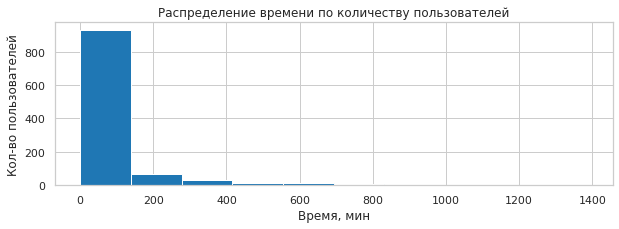

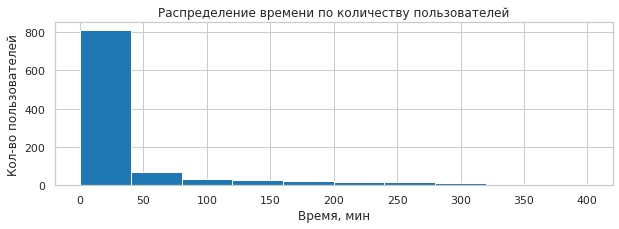

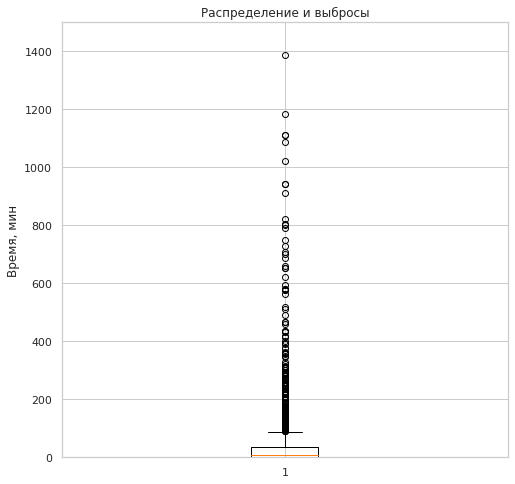

In [65]:
delta_minutes.hist(figsize=(10,3),bins=10)
plt.title('Распределение времени по количеству пользователей')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Время, мин');
plt.show()
delta_minutes.hist(figsize=(10,3),bins=10, range=(0,400));
plt.title('Распределение времени по количеству пользователей')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Время, мин');
plt.show()
plt.figure(figsize=(8,8))
plt.title('Распределение и выбросы')
plt.ylabel('Время, мин');
plt.boxplot(delta_minutes)
plt.ylim(0,1500);

**Вывод** 

Учитывая усредненные, гистограммы и boxplot- конкретное значение усредненного показателя времени от первого события до целевого определить сложно, так как время довольно "плавно" возрастает от нескольких секунд до 23 часов. Так как медиана более устойчива к разбросу, примем ее как приблизительное среднее значение от совершения первого действия в приложении до целевого- 8 минут 31 сек.

### Влияние событий на конверсию в целевое действие

Чтобы определить как каждое действие, совершенное в приложении, влияет на конверсию, составим список уникальных действий: 

In [66]:
events_list = data_all['event_name'].unique()
events_list

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

In [67]:
conv_df = pd.DataFrame(events_list)
conv_df
#conv_df.append(conv)

,0
0,advert_open
1,tips_show
2,map
3,contacts_show
4,search_4
5,search_5
6,tips_click
7,photos_show
8,search_1
9,search_2


Теперь посмотрим как каждое из действий в списке влияет на конверсию:

In [68]:
for i in events_list:
    all_events = data_all.query(f"event_name == '{i}'")['user_id'].unique()
    cont = data_all.query('user_id in @all_events')
    cont = cont.query('event_name == "contacts_show"')['user_id'].unique()
    #len(all_events)
 
    conv = (len(cont)/len(all_events))*100
    print('Конверсия из', i, 'в contacts_show', conv)

Конверсия из advert_open в contacts_show 18.375499334221036
Конверсия из tips_show в contacts_show 18.421992145662262
Конверсия из map в contacts_show 19.8489010989011
Конверсия из contacts_show в contacts_show 100.0
Конверсия из search_4 в contacts_show 18.565400843881857
Конверсия из search_5 в contacts_show 17.194570135746606
Конверсия из tips_click в contacts_show 31.05590062111801
Конверсия из photos_show в contacts_show 30.958904109589042
Конверсия из search_1 в contacts_show 30.1143583227446
Конверсия из search_2 в contacts_show 22.727272727272727
Конверсия из search_3 в contacts_show 18.269230769230766
Конверсия из favorites_add в contacts_show 38.74643874643874
Конверсия из contacts_call в contacts_show 100.0
Конверсия из search_6 в contacts_show 15.757575757575756
Конверсия из search_7 в contacts_show 15.92356687898089


Поместим полученнные данные в датафрейм

In [69]:
d = []
for i in events_list:
    all_events = data_all.query(f"event_name == '{i}'")['user_id'].unique()
    cont = data_all.query('user_id in @all_events')
    cont = cont.query('event_name == "contacts_show"')['user_id'].unique()
    conv = (len(cont)/len(all_events))*100
    
    d.append(
        {
            'event_name': i,
            'conversion in contacts_show': conv
        }
    )

new= pd.DataFrame(d)
new

,event_name,conversion in contacts_show
0,advert_open,18.375499
1,tips_show,18.421992
2,map,19.848901
3,contacts_show,100.000000
4,search_4,18.565401
5,search_5,17.194570
6,tips_click,31.055901
7,photos_show,30.958904
8,search_1,30.114358
9,search_2,22.727273


Отобразим полученные данные на графике

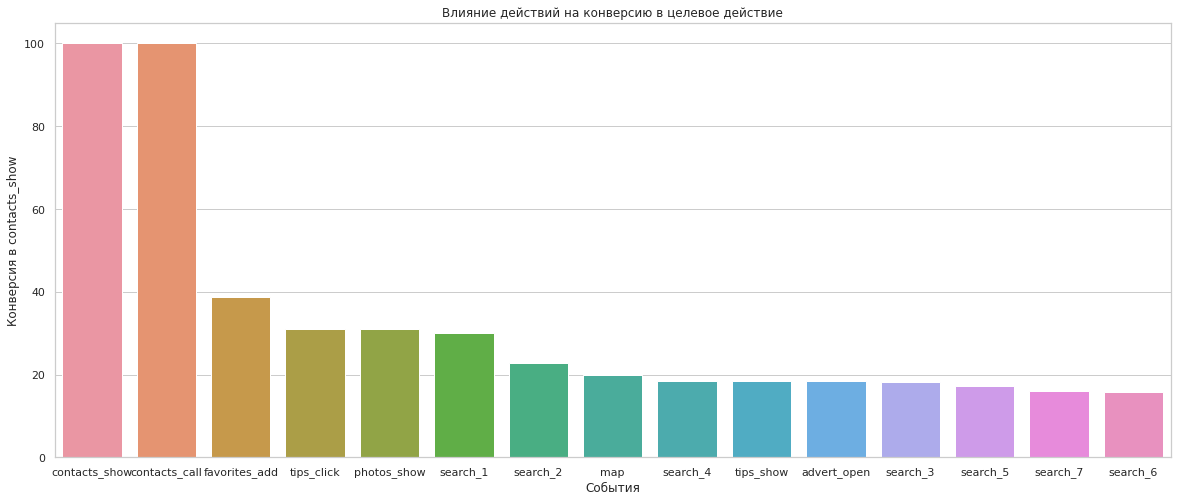

In [70]:
plt.figure(figsize=(20,8))
sns.barplot(data=new, x="event_name", y="conversion in contacts_show", order=new.sort_values('conversion in contacts_show',ascending = False).event_name)
plt.title('Влияние действий на конверсию в целевое действие')
plt.xlabel('События')
plt.ylabel('Конверсия в contacts_show')
plt.show()

**Вывод**


Два события показывают нам 100%-ую конверсию в целевое действие (просмотр контакта). Сам просмотр контакта, который мы не будем просматривать и contacts_call, который вероятнее всего нельзя совершить, не просмотрев контакт.
Следующим по популярности идет действие "добавление в избранное". Действительно, если пользователь настолько заинтересовался товаром, что добавил его в избранное очень высока вероятность того, что он все-таки совершит целевое действие (просмотрит контакт).
tips_click, photos_show и search_1 показывают примерно одинаковую конверсию в целевое действие (около 30%), все остальные события значительно отстают от выше упомянутых и показывают гораздо худшую конверсию в целевое действие.

### Источники привлечения пользователей

Рассмотрим из каких источников приходят пользователи.
Для этого сначала убедимся, что у каждого пользователя только один источник.

In [71]:
data_all.pivot_table(index='user_id', values='source', aggfunc='nunique').source.max()

1

Отобразим на диаграмме разделение количества пришедших пользователей по источникам.

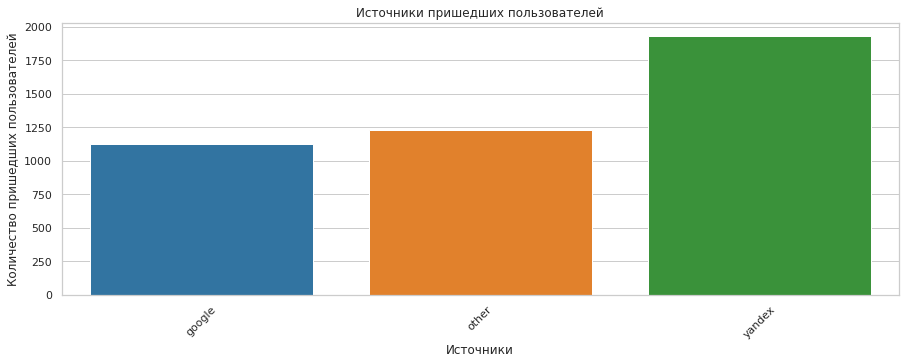

In [72]:
source_count = data_all.groupby('user_id', as_index=False).agg({'source' : 'first'})\
.pivot_table(index='source', values='user_id', aggfunc='count').reset_index()
plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x='source', y='user_id', data=source_count)

plt.xlabel('Источники')
plt.ylabel('Количество пришедших пользователей')
plt.title('Источники пришедших пользователей')

plt.show()

**Вывод**

Яндекс является лидером среди источников загрузки приложения. С google приходит меньше примерно в 1.5 раза, а с остальных ресурсов вместе взятых приходит примерно столько же пользователей как с google.

## Проверка статистических гипотез

**Гипотеза № 1**

Одни пользователи совершают действия tips_show и tips_click, другие - только tips_show.

Гипотеза: конверсия в просмотры контактов различается у этих двух групп

Выделим всех пользователей, кто совершил "tips_show", а затем разделим их на 2 группы - кто совершал "tips_click" и кто нет.

In [73]:
tips_show_users = data_all.query('event_name =="tips_show"')['user_id'].unique().tolist()
print('Количество пользователей, совершивших "tips_show" =', len(tips_show_users))

tips_show_click_users = data_all.query('event_name =="tips_click" and user_id==@tips_show_users')['user_id'].unique().tolist()
print('Количество пользователей, совершивших "tips_show" и "tips_click" =', len(tips_show_click_users))
trial_1 = len(tips_show_click_users)
only_tips_show_users = list(set(tips_show_users) - set(tips_show_click_users))
print('Количество пользователей, совершивших только "tips_show" =', len(only_tips_show_users))
trial_2 = len(only_tips_show_users)

Количество пользователей, совершивших "tips_show" = 2801
Количество пользователей, совершивших "tips_show" и "tips_click" = 297
Количество пользователей, совершивших только "tips_show" = 2504


Посмотрим на конверсию в "contacts_show" всех действий каждой группы. Прежде всего рассмотрим пользователей, совершивших оба действия tips_show и tips_click.

In [74]:
csh_tips_show_click_users = data_all.query('event_name =="contacts_show" and user_id==@tips_show_click_users')['user_id'].unique().tolist()
print('Кол-во пользователей, совершивших целевое событие среди tips_show+click пользователей =', len(csh_tips_show_click_users))
successes_1= len(csh_tips_show_click_users)

Кол-во пользователей, совершивших целевое событие среди tips_show+click пользователей = 91


In [75]:
conversion_tips_show_click_users = len(csh_tips_show_click_users)/len(tips_show_click_users)
conversion_tips_show_click_users = round(conversion_tips_show_click_users*100, 2)
print(f'Конверсия в целевое событие tips_show+click пользователей =', conversion_tips_show_click_users, '%')

Конверсия в целевое событие tips_show+click пользователей = 30.64 %


Далее рассмотрим пользователей, совершивших целевое действие среди тех, кто совершил только tips_show.

In [76]:
csh_tips_show_users = data_all.query('event_name =="contacts_show" and user_id==@only_tips_show_users')['user_id'].unique().tolist()
print('Кол-во пользователей, совершивших целевое событие среди только tips_show пользователей =', len(csh_tips_show_users))
successes_2= len(csh_tips_show_users)

Кол-во пользователей, совершивших целевое событие среди только tips_show пользователей = 425


In [77]:
conversion_tips_show_users = len(csh_tips_show_users)/len(only_tips_show_users)
conversion_tips_show_users = round(conversion_tips_show_users*100, 2)
print(f'Конверсия в целевое событие tips_show пользователей =', conversion_tips_show_users, '%')

Конверсия в целевое событие tips_show пользователей = 16.97 %


Проверка гипотезы будет осуществляться методом о равенстве долей

Формулировка гипотез

Для проверки статистической значимости различий конверсии между группами формулируем гипотезы:

Гипотеза 0 = 'отличие между группами отсутствует, а выявленная разница не является статистически достоверной'

Гипотеза 1 = 'существует отличие между группами, а выявленная разница является статистически достоверной'

Напишем функцию stat_test(successes, trials, alpha), которая проводит тестирование на равенство долей, где
 - successes - количество успешных попыток [группа1, группа2]
 - trials - всего попыток [группа1, группа2]
 - alpha - критический уровень статистической значимости

In [78]:
def stat_test(successes, trials, alpha):  

    alpha = alpha
    successes = successes
    trials = trials
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    # критический уровень статистической значимости
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

alpha = .05 # критический уровень статистической значимости
successes = [successes_1, successes_2]
trials = [trial_1, trial_2]

stat_test(successes, trials, alpha)    

p-значение:  9.218316554537864e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод**

Проверка статистической значимости различий конверсии между группами подтвердила, что существует отличие между группами, а выявленная разница является статистически достоверной.
p-value, полученное в ходе проверки, существенно ниже критического уровеня значимости, что позволяет отвергнуть нулевую гипотезу о равенстве групп.
Пользователи, которые кликают по рекомендованному объявлению, чаще просматривают контакт, чем те, которые только просматривают рекомендованное объявление.

**Гипотеза №2**

Некоторые пользователи добавляют в избранное товар (favorites_add) после просмотра фотографий (photos_show), другие же этого не делают.

Гипотеза: конверсия в просмотр контакта у этих групп различается.

Выделим всех пользователей, просмотревших фотографии в объявлении, а затем разделим их также на 2 группы - кто просмотрел фотографии и добавил объявление в избранное и те, кто только просмотрел фотографии в объявлении.

In [79]:
photos_show_users = data_all.query('event_name =="photos_show"')['user_id'].unique().tolist()
print('Количество пользователей, просмотревших фотографии в объявлении =', len(photos_show_users))

photos_show_favorites_add_users = data_all.query('event_name =="favorites_add" and user_id==@photos_show_users')['user_id'].unique().tolist()
print('Количество пользователей, добавивших объявление в избранное после просмотра фото =', len(photos_show_favorites_add_users))
trial_11 = len(photos_show_favorites_add_users)
only_photos_show_users = list(set(photos_show_users) - set(photos_show_favorites_add_users))
print('Количество пользователей, только просмотревших фото (не добавили в избранное) =', len(only_photos_show_users))
trial_22 = len(only_photos_show_users)

Количество пользователей, просмотревших фотографии в объявлении = 1095
Количество пользователей, добавивших объявление в избранное после просмотра фото = 202
Количество пользователей, только просмотревших фото (не добавили в избранное) = 893


Посмотрим на конверсию в "contacts_show" всех действий каждой группы. 
Прежде всего рассмотрим пользователей, совершивших оба действия photos_show и favorites_add.

In [80]:
csh_photos_show_favorites_add_users = data_all.query('event_name =="contacts_show" and user_id==@photos_show_favorites_add_users')['user_id'].unique().tolist()
print('Кол-во пользователей, просмотревших контакт среди тех, кто посмотрел фото и добавил объявление в избранное =', len(csh_photos_show_favorites_add_users))
success_11 = len(csh_photos_show_favorites_add_users)

Кол-во пользователей, просмотревших контакт среди тех, кто посмотрел фото и добавил объявление в избранное = 76


In [81]:
conversion_photos_show_favorites_add_users = len(csh_photos_show_favorites_add_users)/len(photos_show_favorites_add_users)
conversion_photos_show_favorites_add_users = round(conversion_photos_show_favorites_add_users*100, 2)
print(f'Конверсия в целевое событие пользователей, просмотревших фото и добавивших объявление в избранное =', conversion_photos_show_favorites_add_users, '%')

Конверсия в целевое событие пользователей, просмотревших фото и добавивших объявление в избранное = 37.62 %


Далее рассмотрим пользователей, совершивших целевое действие среди тех, кто совершил только photos_show.

In [82]:
csh_only_photos_show_users = data_all.query('event_name =="contacts_show" and user_id==@only_photos_show_users')['user_id'].unique().tolist()
print('Кол-во пользователей, просмотревших контакт среди тех, кто смотрел фото (не добавив объявление в избранное) =', len(csh_only_photos_show_users))
success_22 = len(csh_only_photos_show_users)

Кол-во пользователей, просмотревших контакт среди тех, кто смотрел фото (не добавив объявление в избранное) = 263


In [83]:
conversion_only_photos_show_users = len(csh_only_photos_show_users)/len(only_photos_show_users)
conversion_only_photos_show_users = round(conversion_only_photos_show_users*100, 2)
print(f'Конверсия в целевое событие пользователей, просмотревших фото (не добавив объявление в избранное) =', conversion_only_photos_show_users, '%')

Конверсия в целевое событие пользователей, просмотревших фото (не добавив объявление в избранное) = 29.45 %


Формулировка гипотез

Для проверки статистической значимости различий конверсии между группами формулируем гипотезы:

Гипотеза 0 = 'отличие между группами отсутствует, а выявленная разница не является статистически достоверной'

Гипотеза 1 = 'существует отличие между группами, а выявленная разница является статистически достоверной'

In [84]:
alpha = .05
successes = [success_11, success_22]
trials = [trial_11, trial_22]

stat_test(successes, trials, alpha) 

p-значение:  0.023278872648960558
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод**

Проверка статистической значимости различий конверсии между группами подтвердила, что существует отличие между группами, а выявленная разница является статистически достоверной.
p-value, полученное в ходе проверки - 0.02, что позволяет отвергнуть нулевую гипотезу о равенстве групп.
Пользователи, которые просматривают фотографии и добавляют объявления в избранное, чаще совершают целевое действие просмотра контактов, чем те, кто лишь просматривает фотографии объявления.

## Общий вывод

- Для анализа нам были представлены данные с 7 октября (00:00) по 3 ноября (23:58) 2019 года. Период времени почти 28 дней
- Количество пользователей, имеющихся в датасете - 4293
- Количество событий, совершенных данными пользователями - 73079
- Среднее количество событий, которое совершает один пользователь за день - 17
- Процент пользователей, совершивших целевое действие (просмотр контакта) от общего количества пользователей - 22.85 %
- В среднем каждый пользователь совершил от 1 до 4 целевых действий (из 981 пользователей, совершавших просмотр контакта) за весь период 
- С момента первого события в приложении до совершения целевого действия, в среднем проходило около 8 минут.
- Самые частые события, среди тех, что пользователь совершал по своей воле в начале сессии- просмотр карты, поиск по сайду и просмотр рекомендованных объявлений.
- Добавление в избранное показывает лучшую конверсию в целевое действие.
- Самым популярным источником прихода пользователей является Яндекс.


Время, проведенное в приложении, у пользователей очень сильно разнится. Кто-то приходит на сайт за конкретным товаром, кто-то, возможно, занимает так свое свободное время, поэтому сессия может занимать от нескольких секунд до 23 часов. 
Как было принято, в среднем, пользователь во время сессии будет совершать в районе четырех действий по сайту. К целевому действию (просмотр контакта) он может прийти уже после первого шага, а может и совершив несколько действий в приложении. В основном пользователи просматривают контакт после просмотра рекомендованного объявления, просмотра карты или после поиска по сайту. Добавление в избранное показывает нам наилучшую конверсию, поэтому разработчикам следует стимулировать пользователей добавлять, например, просмотренный несколько раз товар в избранное или же показывать ему объявление как рекомендуемое. Просмотр фотографий также улучшает конверсию в целевое действие, поэтому этот пункт можно сделать обязательным для продавцов для размещения своего товара в нашем приложении. Все поиски, кроме search_1, показывают плохие результаты и мало используются пользователями, их нужно либо доработать, либо упразднить.